# 計画

第１近似
1. 上下5％をカットした残りからサンプル点を抽出し、５次ベジエ曲線で近似
2. 平均により上下それぞれ中心軸の関数記述を得る。（パラメータを共有していると考えると、中心軸の制御点は左右制御点の重心
3. えられた中心軸関数（５次）に基づいてサンプル点を生成し、３次ベジエ曲線で近似（＊補足）

第２近似
1. 左右対称の輪郭を得るために、中心軸上端、軸の延長上に中心をもつ円で上端輪郭を削る。下端は第１近似と同じ、配置状態で、下から５％を削る。（＊補足２）
2. 輪郭点集合が左右に分かれるので、それぞれを５次のベジエ曲線で近似

原型復元
1. 各点に対応する左右輪郭点を求め、軸点と輪郭点の距離を x とする。
2. 中心軸上の各点に対し中心軸の上端（または下端）を基準とした距離を求め、y とする。
3. (x,y) をプロットすることにより対称図形として復元

In [1]:
from sympy import *
from sympy.abc import a,b,c
import numpy as np
%matplotlib inline
from sympy import var
from rdlib2 import *
UNIT = 256


IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



In [14]:
def threeLinesSeqR4(img, showImage =  False, n_samples=20, N=3, M=5, C=3,debugmode=False, openmode=False, precPara1=0.1,precPara2=0.01,cutEnd=5): 
    # N 初期近似での近似次数
    # M 再近似での近似次数
    # C 中心線の近似次数
    # cutEnd  再近似時の上端の削り調整数
    _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    # バウンダリ矩形を得る
    x0,y0,w,h = cv2.boundingRect(img)
    cnt = contours[0]
    canvas = np.zeros_like(img)
    # 輪郭線の描画
    canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)
    # 上下端それぞれ5％は歪みが大きいので一旦カット   
    cut05 = y0+int(5*h/100) # シルエッ上端から高さ5％の位置
    cut95 = y0+int(95*h/100) # シルエッ下端から高さ95％の位置

    # 左右のベジエ曲線の平均をもとにして中央のベジエ曲線を求める。
    def getcenterBez(bezXl,bezXr,bezYl,bezYr,C=C):
        # 左右のベジエ曲線の平均を求める
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        # 基本的にはこれが中心軸を表すが、5次だと両端に弊害が現れることが多いので次数を減らすためにサンプル点を生成して3次で近似する
        csamples = [[float(bezXc.subs(t,i)),float(bezYc.subs(t,i))] for i in np.linspace(0, 1, n_samples)] # サンプル点を生成
        csamples = np.array(csamples)
        cpxc,cpyc,bezXc,bezYc,tpc = fitBezierCurveN(csamples,precPara=precPara２,N=C,openmode=openmode,debugmode=debugmode)
        return cpxc,cpyc,bezXc,bezYc

    # 仮の中心軸を決めるために左右の輪郭の近似記述を得、平均により軸の仮記述とする
    def phase1(): 
        canvas[0:cut05,:]=np.zeros((cut05,img.shape[1]))
        canvas[cut95+1:,:]=np.zeros((img.shape[0]-(cut95+1),img.shape[1]))    
        # 輪郭検出すれば２つの輪郭が見つかるはず。
        _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # 線図形の輪郭は中間で折り返しになっている
        cnt0 = contours[0][:int(len(contours[0])/2+1)]
        cnt1 = contours[1][:int(len(contours[1])/2+1)]
        # 中程の点を比べて左にある方を左と判定する。
        c0 = cnt0[int(len(cnt0)/2)][0][0]
        c1 = cnt1[int(len(cnt1)/2)][0][0]
        if  c0 > c1: 
            cntL,cntR = cnt1,cnt0
        else:
            cntR,cntL = cnt1,cnt0
        # print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))]
        cntl = np.array([[x,y] for [[x,y]] in cntl])
        cntr = np.array([[x,y] for [[x,y]] in cntr])
        
        # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
        datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=precPara1,N=N,openmode=openmode,debugmode=debugmode)
        datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=precPara1,N=N,openmode=openmode,debugmode=debugmode)
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        # cpxc,cpyc,bezXc,bezYc = getcenterBez(bezXl,bezXr,bezYl,bezYr) # この段階ではこれを使ってはいけない
        return cntl,cntr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc
    cntl,cntr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc = phase1()
    print('Phase1 finished')
    
        # 結果の描画
    if showImage:
        tplinsOver = np.linspace(-0.03, 1.03,55)
        tplinsLong = np.linspace(-0.3, 1.3,50)
        tplins50 = np.linspace(0, 1, 50)
        tplins20 = np.linspace(0, 1, 20)
        plt.figure(figsize=(6,6),dpi=100)
        plt.gca().invert_yaxis() 
        plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
        # 左輪郭の描画
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
        # plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        #for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))
        # 右輪郭の描画
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
        #  plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        #for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
        # 中心軸の描画
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        
        plot20lx = [bezXl.subs(t,tp) for tp in tplins20 ]
        plot20ly = [bezYl.subs(t,tp) for tp in tplins20 ]
        plot20cx = [bezXc.subs(t,tp) for tp in tplins20 ]
        plot20cy = [bezYc.subs(t,tp) for tp in tplins20 ]
        plot20rx = [bezXr.subs(t,tp) for tp in tplins20 ]
        plot20ry = [bezYr.subs(t,tp) for tp in tplins20 ]
        
        p0,p1 = symbols('p0,p1')
        bez1 = (1-t)*p0 + t*p1
        
        for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 
        for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 

    #  得られた仮中心線を基にして輪郭上部をできるだけ軸対称になるよう左右輪郭を取り直す
    def phase2(bezXl,bezYl,bezXr,bezYr,bezXc,bezYc):
        # 得られ左右輪郭のパラメータの一致する点同士を結んだ線分をその位置での仮の幅として仮の最大幅を求める。
        max_width = 0
        max_level = 0
        levels = np.linspace(0, 1, 101)
        for lev in levels:
            xL = bezXl.subs(t,lev)
            yL = bezYl.subs(t,lev)
            xR = bezXr.subs(t,lev)
            yR = bezYr.subs(t,lev)
            w = np.sqrt(float((xL-xR)**2) + float((yL-yR)**2))
            if w > max_width:
                max_width = w
                max_level = lev
        # ループを抜けると最大幅とその時のパラメータ値が得られている。
    
        # 再び輪郭を描く
        _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
        x0,y0,w,h = cv2.boundingRect(img)
        cnt = contours[0]
        canvas = np.zeros_like(img)
        # 輪郭線の描画
        canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)
        # 高次のベジエ近似の平均を中心軸の記述に使うと端部の傾きが異常になることが多いので、低次で近似し直す
        cpxc,cpyc,bezXc,bezYc = getcenterBez(bezXl,bezXr,bezYl,bezYr,C=C) # 中心軸のベジエ近似  
        # 中心軸を元に左右の輪郭を再度求め直す
        cntL,cntR = segmentLR(img,cnt,bezXc,bezYc,bezXl,bezXr,dmax=max_width,cutEnd=cutEnd,bottomcutLevel=cut95)
        return cntL,cntR
    cntL,cntR = phase2(bezXl,bezYl,bezXr,bezYr,bezXc,bezYc)
    print('Phase2 finished')
    
    # 再近似
    def phase3(cntl,cntr):
        # 左右をそれぞれ５次のベジエ 曲線で近似し、あらためて中心線と最大幅を得る。
        # リサンプリング
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))] 
        # 再ベジエ 近似
        datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=precPara2,N=M,openmode=openmode,debugmode=debugmode)
        datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=precPara2,N=M,openmode=openmode,debugmode=debugmode)
        return cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr
    cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr = phase3(cntl = cntL,cntr = cntR)
    print('Phase3 finished')
    
    # 中心軸に等間隔にサンプル点を取り（２０個）、その点での法線の方程式に輪郭のベジエ 表現式を代入して５次方程式を解き、
    # 法線と左右の輪郭の交点を求める。
    def phase4(bezXr,bezYr,bezXl,bezYl):
        ## 左右のベジエ曲線の平均を求める
        # bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        ## 基本的にはこれが中心軸を表すが、5次だと両端に弊害が現れることが多いので次数を減らすためにサンプル点を生成して3次で近似する
        # csamples = [[float(bezXc.subs(t,i)),float(bezYc.subs(t,i))] for i in np.linspace(0, 1, n_samples)] # 20のサンプル点を生成
        # csamples = np.array(csamples)
        print("中心軸の最終決定")
        # cpxc,cpyc,bezXc,bezYc,tpc = fitBezierCurveN(csamples,precPara=precPara２,N=C,openmode=openmode,debugmode=debugmode)
        cpxc,cpyc,bezXc,bezYc = getcenterBez(bezXl,bezXr,bezYl,bezYr,C=C )
        PlistL,PlistR = [],[]
        x0,y0 = var('x0,y0')
        for i in np.linspace(0, 1, 20):
            y0 = float(bezYc.subs(t,i))
            x0 = float(bezXc.subs(t,i))
            dx = diff(bezXc,t).subs(t,i) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = diff(bezYc,t).subs(t,i)
            ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t) # 法線とベジエ輪郭の交点を求める
            ansR = [re(i) for i in ans if float(Abs(im(i)))<0.00001]
            s = [i for i in ansR if  i<=1 and 0<=i]
            PlistR.append(s)
        for i in np.linspace(0, 1, 20):
            y0 = float(bezYc.subs(t,i))
            x0 = float(bezXc.subs(t,i))
            dx = float(diff(bezXc,t).subs(t,i)) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = float(diff(bezYc,t).subs(t,i))
            ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t) # 法線とベジエ輪郭の交点を求める
            ansL = [re(i) for i in ans if float(Abs(im(i)))<0.00001]
            s = [i for i in ansL if  i<=1 and 0<=i]
            PlistL.append(s)
           
        # 定積分により軸に沿った長さを求める
        '''dxdt = diff(bezXc,t)
        dydt = diff(bezYc,t)
        leng = integrate(sqrt(dxdt**2+dydt**2),(t,0,s))
        radiusTable = []
        for i, tpara in enumerate(np.linspace(0,1,20)):
            print(PlistL,PlistR)
            len = float(leng.subs(s,tpara)) # 上端からの長さ
            if PlistL[i] != [] and PlistR[i] != []:
                radishR = float((PlistL[i][0]+PlistR[i][0])/2) # 太さ
                radiusTable.append([len,radishR]) 
            else:
                radiusTable.append([len,np.inf]) '''
        
        #結果の描画
        if showImage:
            tplins50 = np.linspace(0, 1, 50)
            tplins20 = np.linspace(0, 1, 20)
            plt.figure(figsize=(6,6),dpi=100)
            plt.gca().invert_yaxis() 
            plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
            plt.imshow(192+(cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8))

            # 左輪郭の描画
            plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            # plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
            plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
            for i in range(M+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))

            # 右輪郭の描画
            plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            #plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
            plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
            for i in range(M+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
            # 中心軸の描画
            plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
        
            # 幅線の描画
            plot20lx = [bezXl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL ]
            plot20ly = [bezYl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL]
            plot20cx = [bezXc.subs(t,tp) for tp in np.linspace(0, 1, 20) ]
            plot20cy = [bezYc.subs(t,tp) for tp in np.linspace(0, 1, 20) ]
            plot20rx = [bezXr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
            plot20ry = [bezYr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
        
            # 内分点の定義式（１次のベジエ ）
            p0,p1 = symbols('p0,p1')
            bez1 = (1-t)*p0 + t*p1
        
            for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
                if x0 != [] and y0 !=[]:
                    fx = bez1.subs([(p0,x0),(p1,x1)])
                    fy = bez1.subs([(p0,y0),(p1,y1)])
                    plot20x = [fx.subs(t,tp) for tp in tplins20]
                    plot20y = [fy.subs(t,tp) for tp in tplins20]
                    plt.plot(plot20x,plot20y,color = 'orange') 
            for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
                if x0 != [] and y0 !=[]:
                    fx = bez1.subs([(p0,x0),(p1,x1)])
                    fy = bez1.subs([(p0,y0),(p1,y1)])
                    plot20x = [fx.subs(t,tp) for tp in tplins20]
                    plot20y = [fy.subs(t,tp) for tp in tplins20]
                    plt.plot(plot20x,plot20y,color = 'orange') 
    
        return cpxc,cpyc,bezXc,bezYc # radiusTable
    cpxc,cpyc,bezXc,bezYc = phase4(bezXr,bezYr,bezXl,bezYl)
    print('Phase4 finished')
        
    return cntl,cntr,cpxl,cpyl,cpxr,cpyr,cpxc,cpyc,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc #,radiusTable
            
# 中心軸情報をもとに輪郭データを左右に分ける
def segmentLR(img,cnt,bezX,bezY,bezXl,bezXr,dmax,cutEnd=5,bottomcutLevel = 10):
    # あらためて概形画像から輪郭線を抽出
    #  img 画像 サイズの参照だけ
    # bezX,bezY 中心軸近似ベジエ曲線
    # dmax 最大直径
    # tcutRatio上部を削るために描く円の半径に掛ける倍率
    # bottomcutRadius　下部を削るために描く円の半径
    
    # 輪郭線の描画
    canvas = np.zeros_like(img)
    canvas = cv2.drawContours(canvas, cnt, -1, 255, thickness=1)
    # 中心軸の延長で上端から最大径離れた地点を中心に最大直径より少し大きな円を０で描き輪郭を削る。
    dy = float((diff(bezY,t)).subs(t,0.05))
    dx = float((diff(bezX,t)).subs(t,0.05)) # t=0 は境界なので変な値にあることがあるため 0.05 としている
    acc = dy/dx if dx != 0 else np.inf # 中心軸の傾き
    x00 = bezX.subs(t,0) #  軸の再上端
    y00 = bezY.subs(t,0)
    xdd = dmax*dx/sqrt(dx**2+dy**2) # x方向にこれだけ進むと dmax 離れる
    x11 = x00-xdd
    y11 =  y00-xdd*acc if acc != np.inf else y00-dmax 
    xl0,xr0=bezXl.subs(t,0),bezXr.subs(t,0) # 最初のサンプル輪郭の左右の上端
    ref_x = xl0 if acc >0 else xr0 
    dia = np.sqrt(float(ref_x-x11)**2+float(y11-y00)**2)+cutEnd
    canvas =  cv2.circle(canvas,(int(x11),int(y11)),int(dia),0,-1)
    # 下端を削る
    canvas[bottomcutLevel+1:,:]=np.zeros((img.shape[0]-(bottomcutLevel+1),img.shape[1])) 
        
    plt.figure(figsize=(6,6),dpi=100)    
    plt.imshow(canvas)
    
    # 輪郭検出すれば２つの輪郭が見つかるはず。
    _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 線図形の輪郭は中間で折り返しになっている
    cnt0 = contours[0][:int(len(contours[0])/2+1)]
    cnt1 = contours[1][:int(len(contours[1])/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
        cntL,cntR = cnt1,cnt0
    else:
        cntR,cntL = cnt1,cnt0
    print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
    #  ２重かっこを１重に変換し、numpy array にしてから返す
    cntL = np.array([[x,y] for [[x,y]] in cntL])
    cntR = np.array([[x,y] for [[x,y]] in cntR])                
    return cntL,cntR

Phase1 finished
左輪郭点の数  218 　右輪郭点の数　 231
Phase2 finished
diffpara 0.024453386664390647
diffpara 0.0
diffpara 0.027839697897434318
diffpara 0.009999997913837433
Phase3 finished
中心軸の最終決定
diffpara 0.05995527282357224
diffpara 0.03500000387430191
diffpara 0.02500005066394806
diffpara 0.024999983608722687
diffpara 0.02499997615814209
diffpara 0.019999980926513672
diffpara 0.020000025629997253
diffpara 0.020000025629997253
diffpara 0.024999983608722687
diffpara 0.009999990463256836
Phase4 finished


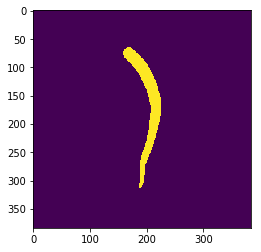

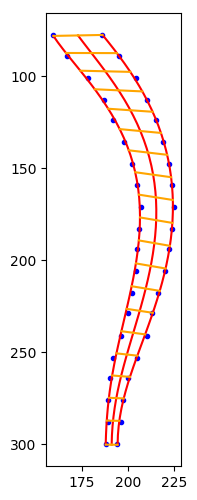

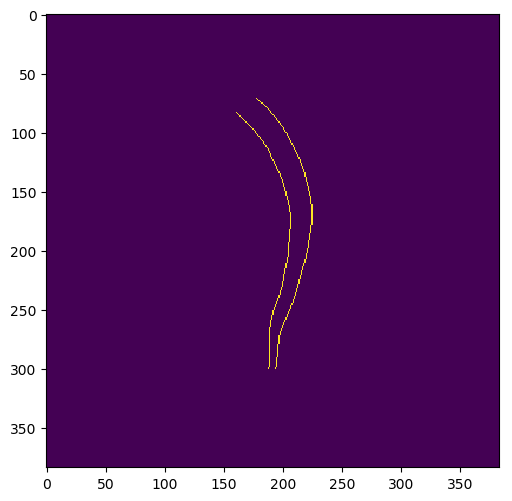

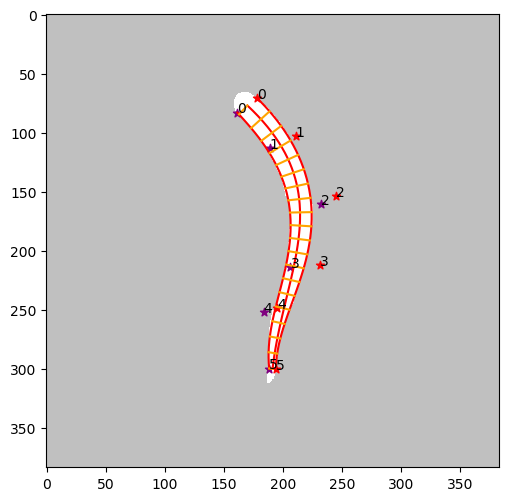

In [85]:
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)
cntl,cntr,cpxl,cpyl,cpxr,cpyr,cpxc,cpyc,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc  = threeLinesSeqR4(img, showImage =True, n_samples=20, N=5, debugmode=False, open=True)

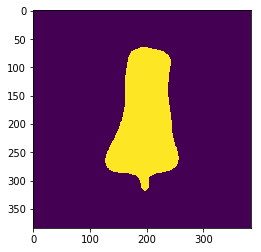

In [65]:
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img);

Phase1 finished
左輪郭点の数  266 　右輪郭点の数　 254
Phase2 finished
diffpara 0.1269507538527251
diffpara 0.07999996095895767
diffpara 0.08500005304813385
diffpara 0.05499996244907379
diffpara 0.029999971389770508
diffpara 0.034999966621398926
diffpara 0.02499997988343239
diffpara 0.034999996423721313
diffpara 0.01499999314546585
diffpara 0.010000050067901611
diffpara 0.010000050067901611
diffpara 0.0
diffpara 0.10543630644679078
diffpara 0.09499993920326233
diffpara 0.07500008307397366
diffpara 0.04500003904104233
diffpara 0.029999971389770508
diffpara 0.04499995708465576
diffpara 0.029999971389770508
diffpara 0.025000065565109253
diffpara 0.019999980926513672
diffpara 0.03499997407197952
diffpara 0.020000040531158447
diffpara 0.009999990463256836
Phase3 finished
中心軸の最終決定
diffpara 0.0294915661215783
diffpara 0.0
Phase4 finished


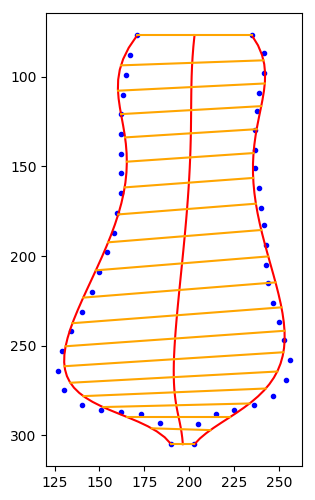

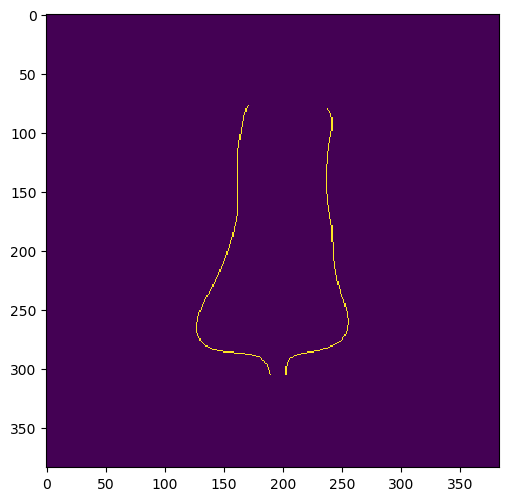

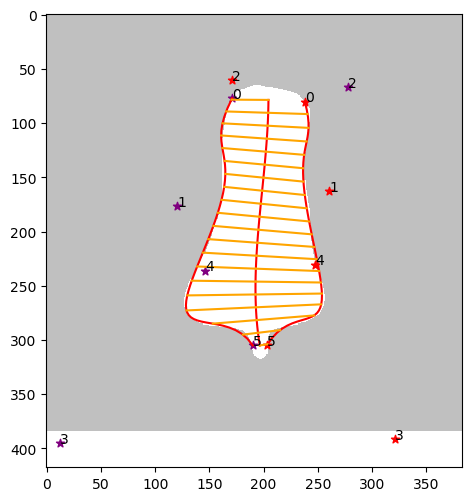

In [66]:
cntl,cntr,cpxl,cpyl,cpxr,cpyr,cpxc,cpyc,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc  = threeLinesSeqR4(img, showImage =True, n_samples=25, N=5, debugmode=False, openmode=False)

Phase1 finished
左輪郭点の数  240 　右輪郭点の数　 257
Phase2 finished
diffpara 0.05591157078742989
diffpara 0.03499998897314072
diffpara 0.040000028908252716
diffpara 0.030000008642673492
diffpara 0.04499998688697815
diffpara 0.025000005960464478
diffpara 0.02499997615814209
diffpara 0.02499997615814209
diffpara 0.019999995827674866
diffpara 0.024999991059303284
diffpara 0.014999985694885254
diffpara 0.01999998837709427
diffpara 0.009999990463256836
diffpara 0.06681326404213914
diffpara 0.04499996080994606
diffpara 0.049999989569187164
diffpara 0.03500000387430191
diffpara 0.019999980926513672
diffpara 0.03499998897314072
diffpara 0.020000040531158447
diffpara 0.019999980926513672
diffpara 0.009999990463256836
Phase3 finished
中心軸の最終決定
diffpara 0.017322402447462165
diffpara 0.004999995231628418
Phase4 finished


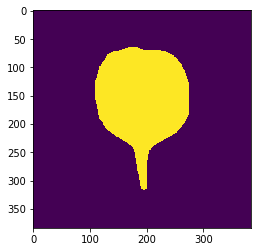

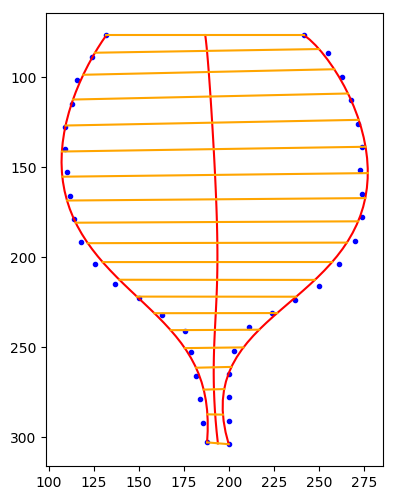

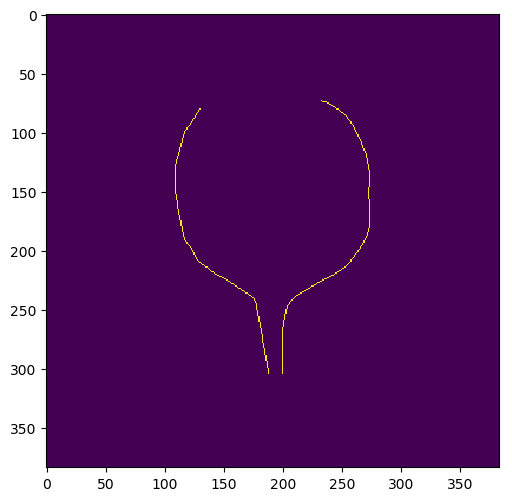

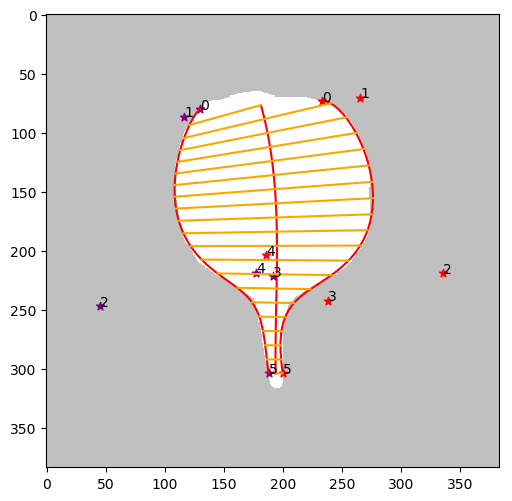

In [67]:
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)
cntl,cntr,cpxl,cpyl,cpxr,cpyr,cpxc,cpyc,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc  = threeLinesSeqR4(img, showImage =True, n_samples=20, N=5, debugmode=False, openmode=False)

Phase1 finished
左輪郭点の数  231 　右輪郭点の数　 226
Phase2 finished
diffpara 0.02458055689930924
diffpara 0.0
diffpara 0.02585544437170037
diffpara 0.0
Phase3 finished
中心軸の最終決定
diffpara 0.014893420040607536
diffpara 0.0
Phase4 finished


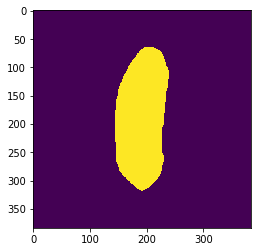

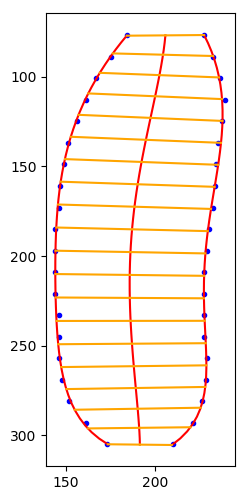

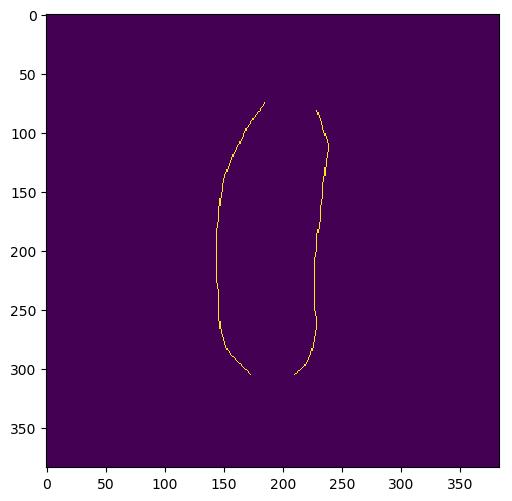

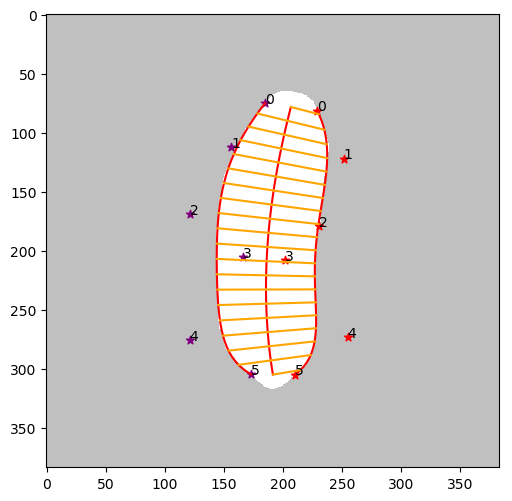

In [68]:
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)
cntl,cntr,cpxl,cpyl,cpxr,cpyr,cpxc,cpyc,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc  = threeLinesSeqR4(img, showImage =True, n_samples=20, N=5, debugmode=False, openmode=True)

# 近似次数での結果の違い
## 2次

Phase1 finished
左輪郭点の数  235 　右輪郭点の数　 227
Phase2 finished
diffpara 0.09961049444973469
diffpara 0.004999995231628418
diffpara 0.04743900615721941
diffpara 0.0
Phase3 finished
中心軸の最終決定
diffpara 0.031591426581144416
diffpara 0.0
Phase4 finished


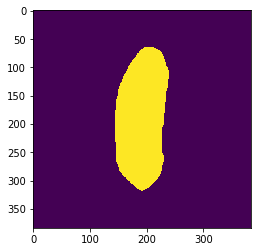

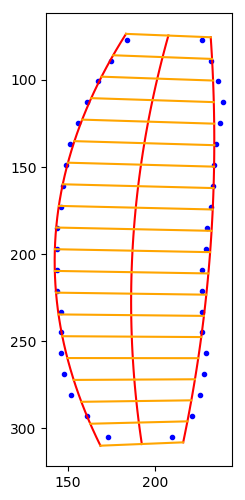

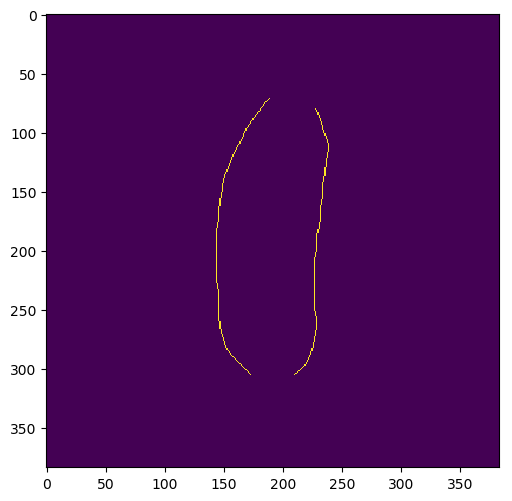

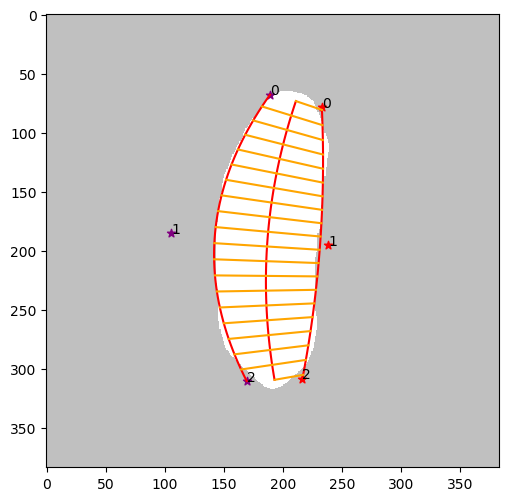

In [91]:
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=20, N=2, M=2,C=2,debugmode=False, openmode=True);

# 輪郭３次、軸２次

Phase1 finished
左輪郭点の数  233 　右輪郭点の数　 224
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished


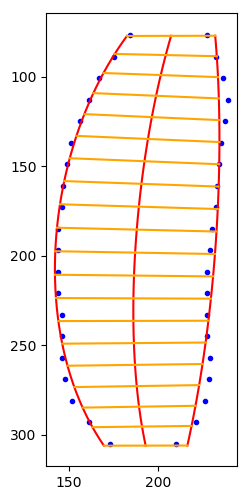

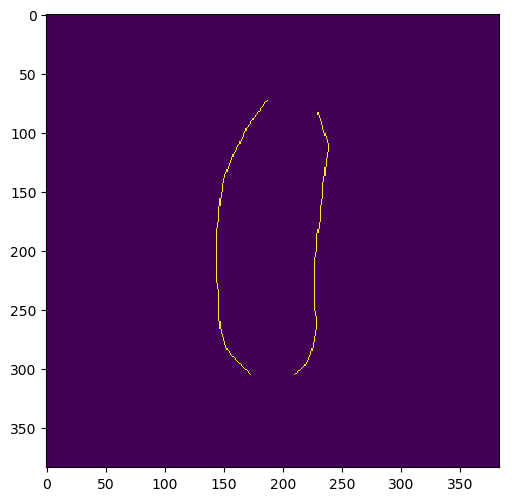

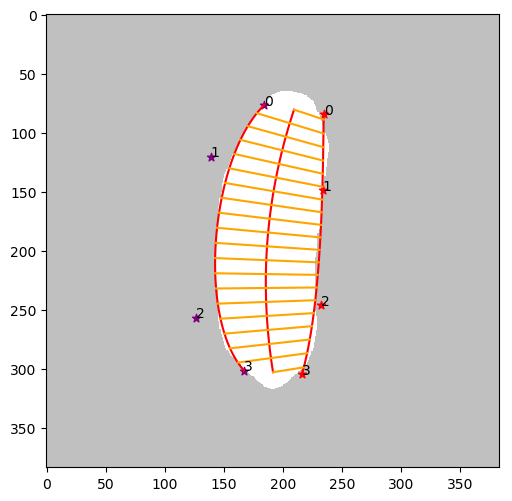

In [130]:
threeLinesSeqR4(img, showImage =True, n_samples=20, N=3, M=3,C=2,debugmode=False, openmode=True);

# 4次

Phase1 finished
左輪郭点の数  230 　右輪郭点の数　 225
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished


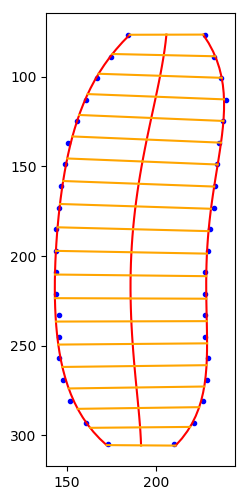

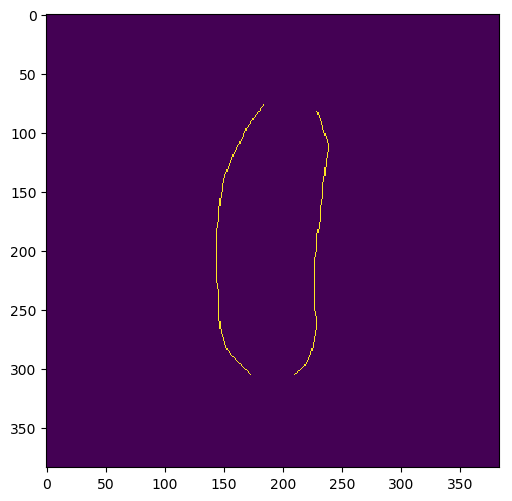

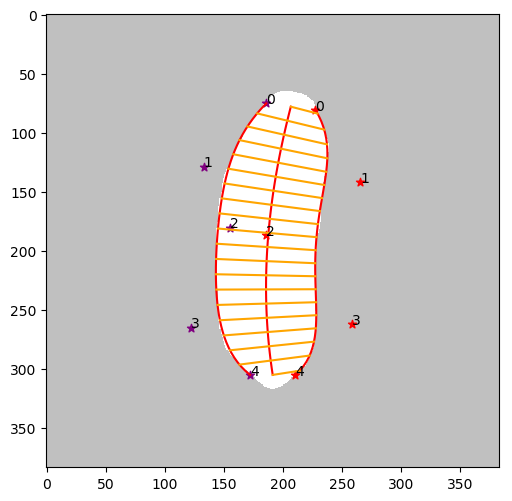

In [131]:
threeLinesSeqR4(img, showImage =True, n_samples=20, N=4, M=4,C=3,debugmode=False, openmode=True);

Phase1 finished
左輪郭点の数  229 　右輪郭点の数　 224
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished


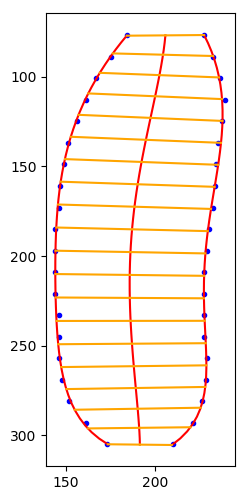

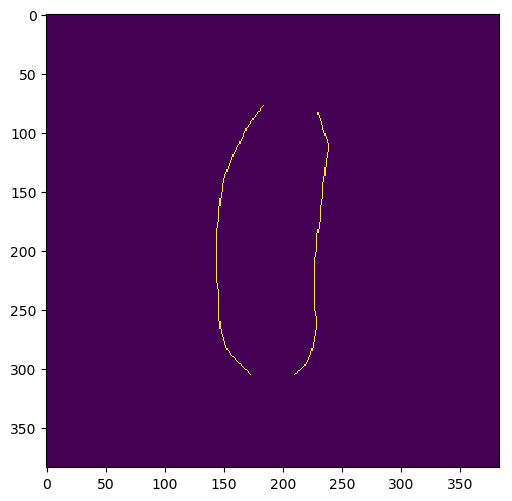

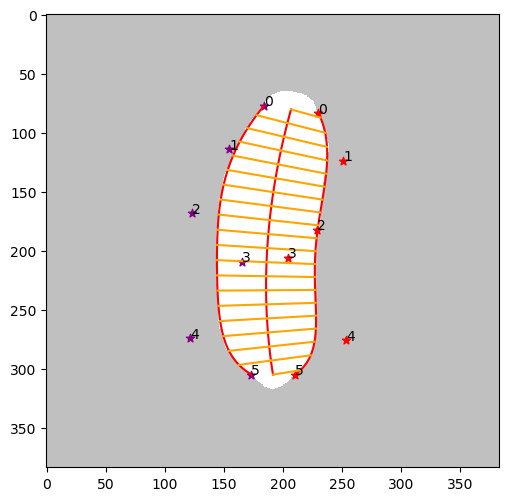

In [132]:
threeLinesSeqR4(img, showImage =True, n_samples=20, N=5, M=5,C=3,debugmode=False, openmode=True);

Phase1 finished
左輪郭点の数  259 　右輪郭点の数　 251
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished


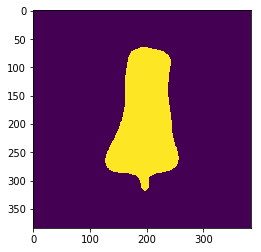

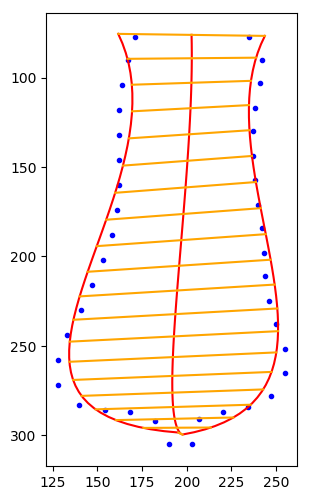

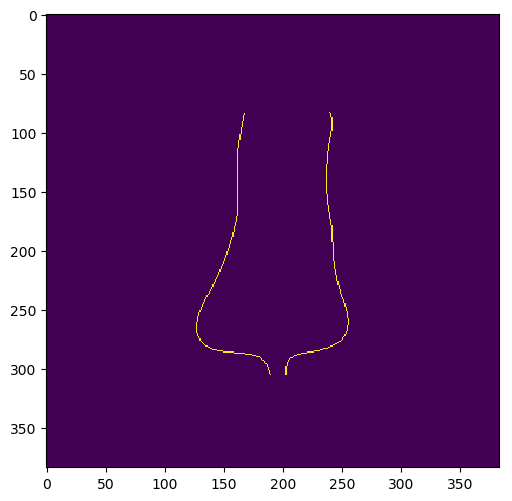

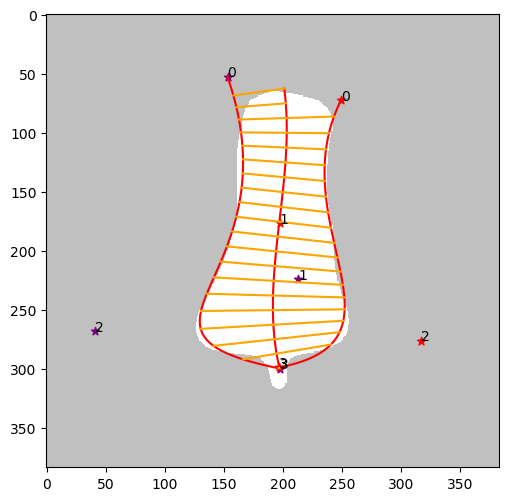

In [134]:
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img);
threeLinesSeqR4(img, showImage =True, n_samples=20, N=3, M=3,C=3,debugmode=False, openmode=True);

Phase1 finished
左輪郭点の数  263 　右輪郭点の数　 251
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished


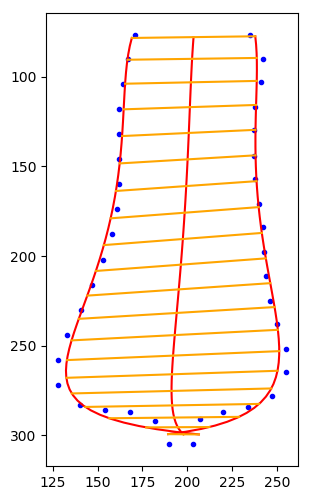

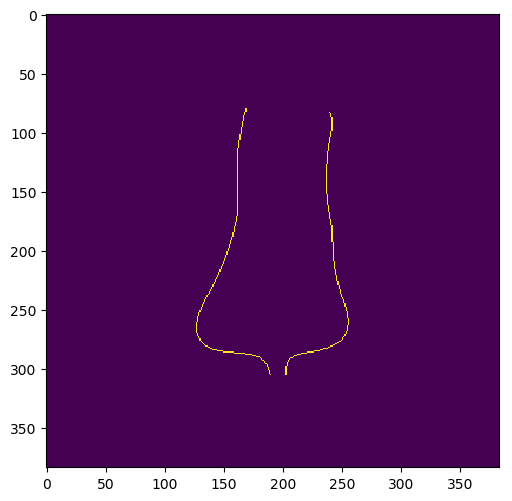

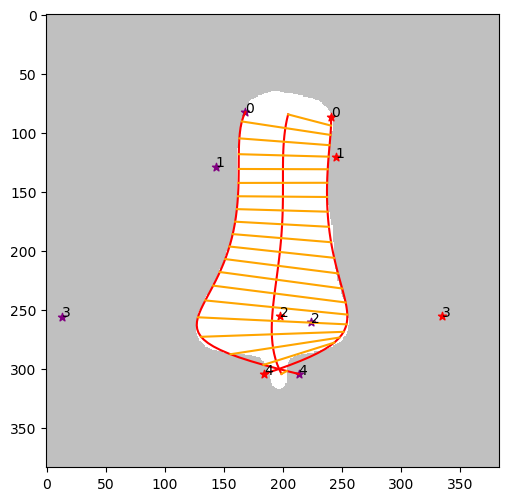

In [135]:
threeLinesSeqR4(img, showImage =True, n_samples=20, N=4, M=4,C=4,debugmode=False, openmode=True);

Phase1 finished
左輪郭点の数  270 　右輪郭点の数　 254
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished


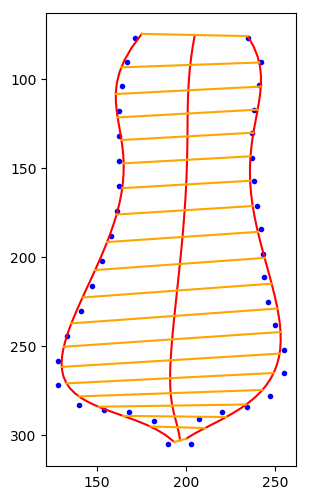

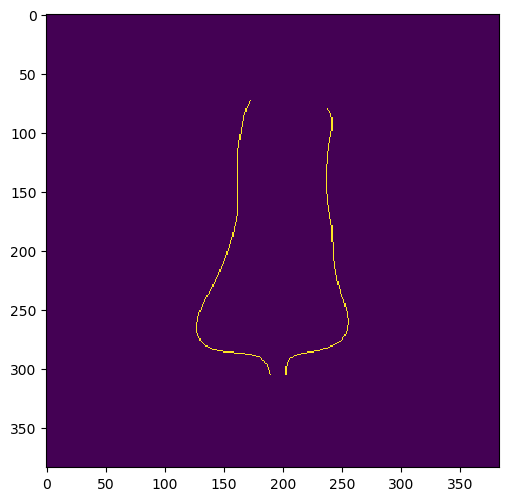

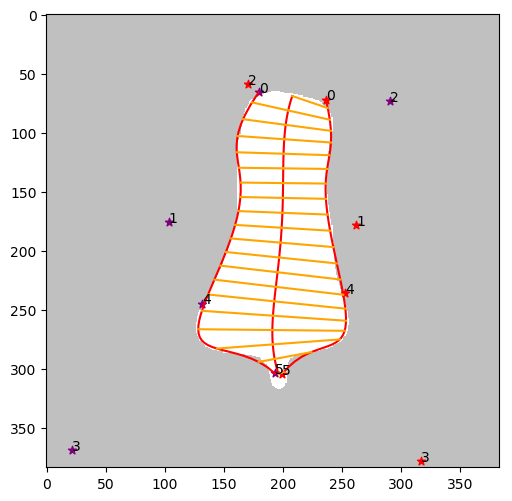

In [136]:
threeLinesSeqR4(img, showImage =True, n_samples=20, N=5, M=5,C=5,debugmode=False, openmode=True);

Phase1 finished
左輪郭点の数  264 　右輪郭点の数　 252
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished


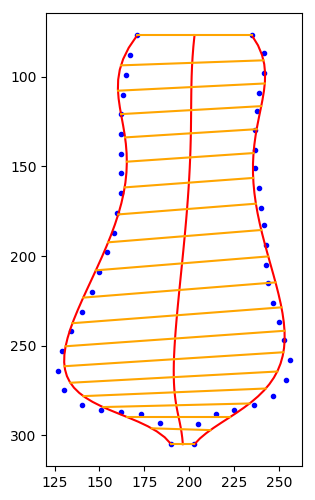

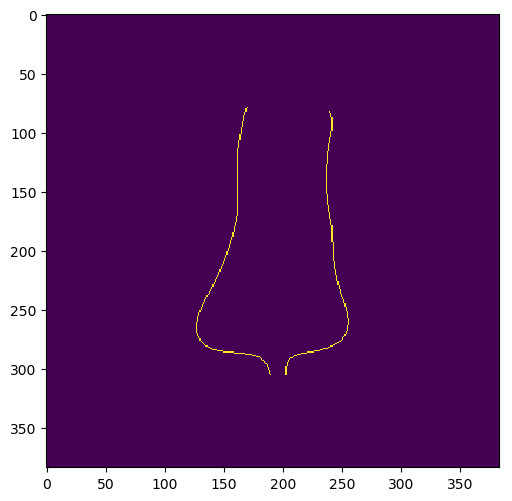

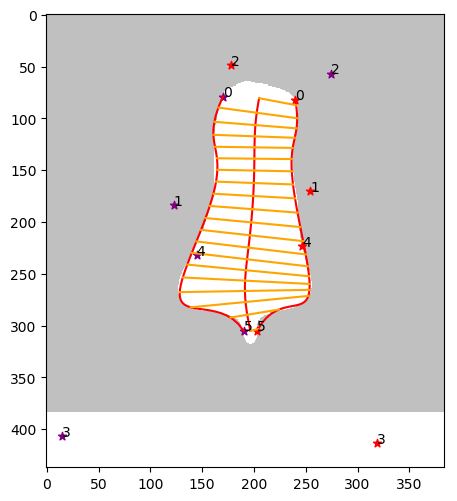

In [137]:
threeLinesSeqR4(img, showImage =True, n_samples=25, N=5, M=5,C=5,debugmode=False, openmode=False);

Phase1 finished
左輪郭点の数  264 　右輪郭点の数　 252
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished


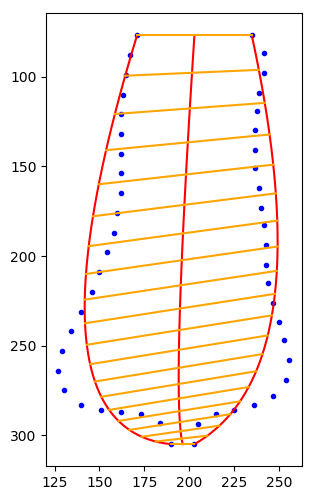

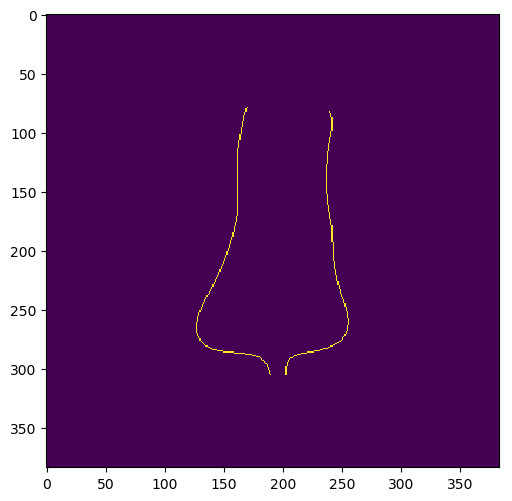

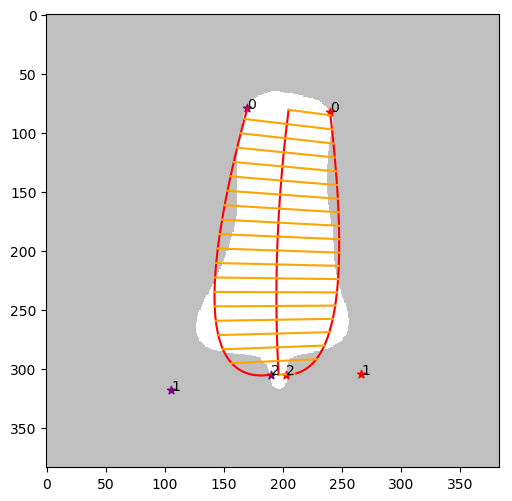

In [138]:
threeLinesSeqR4(img, showImage =True, n_samples=25, N=2, M=2,C=2,debugmode=False, openmode=False);

# 例外的な失敗例

次の例は、２次ベジエ近似でオープンモード（両端フリー）で実行したケースであるが、上端の制御点がサンプル点よりかなり上寄りに移動してしまった。再サンプリングの際に上端を均等に削ることで左右の輪郭を分けるのだが、その際に上端制御点の位置を基準としているため、この例では上端を削るのに失敗し、輪郭が左右に分割されていない。それ以降の処理は左右分割が前提となっているので、そこから後前提が崩れてエラーとなった。

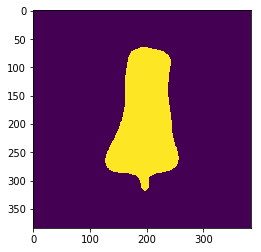

In [15]:
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img);

Phase1 finished


IndexError: list index out of range

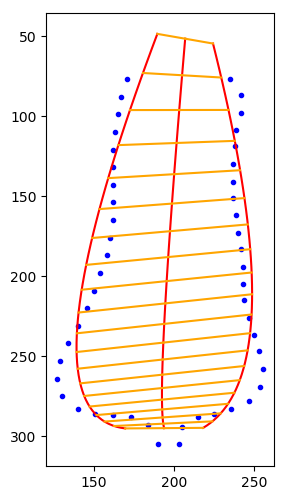

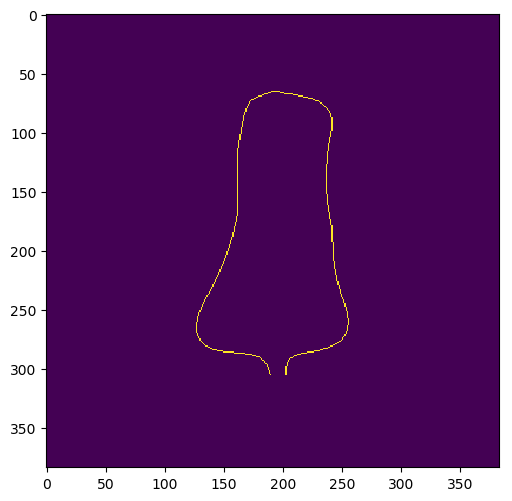

In [16]:
threeLinesSeqR4(img, showImage =True, n_samples=25, N=2, M=2,C=2,debugmode=False, openmode=True);

In [ ]:
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=20, N=2, M=2,C=2,debugmode=False, openmode=True);